## Importing the dataset

In [2]:
import numpy as np 
import pandas as pd

column_names = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

df=pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1', names=column_names, header=None)
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Feature Engineering

In [3]:
df = df[['sentiment','text']]
print(len(df))
df.head()

1600000


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(sentence):
    # Removing URLs and HTML tags
    sentence = re.sub(r"https?://\S+|www\.\S+|<.*?>", " ", sentence)
    
    # Removing non-alphanumeric characters and digits
    sentence = re.sub(r"[^\w\s]", " ", sentence)
    
    # Converting to lowercase
    sentence = sentence.lower()
    
    # Splitting sentence into words
    words = sentence.split()
    
    # Removing stopwords and digits from words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and not word.isdigit()]
    
    # Joining filtered words back into a sentence
    cleaned_sentence = " ".join(filtered_words)
    
    return cleaned_sentence

# Applying clean_text function to 'text' column of DataFrame
df['clean_text'] = df['text'].apply(clean_text)


In [5]:
df.head()

,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save re...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see


In [6]:
X= df['clean_text']
y= df['sentiment']
y[y == 4] = 1
print(y.head())
print(len(X))

0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64
1600000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
unique_classes = df['sentiment'].unique()

# Print the unique classes
print("Unique Classes:", unique_classes)

Unique Classes: [0 1]


## Splitting the dataset in train and test split

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print('X Train Shape: ',X_train.shape)
print('X Test Shape: ',X_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)


X Train Shape:  (1280000,)
X Test Shape:  (320000,)
Y Train Shape:  (1280000,)
Y Test Shape:  (320000,)


## Building deep learn model

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(X_train)
sequence_train=tokenizer.texts_to_sequences(X_train)
sequence_test=tokenizer.texts_to_sequences(X_test)

In [10]:
# Assuming you have already executed the preprocessing steps
print("Original Text:", X_train[1])
print("Tokenized Sequence:", sequence_train[1])
print(tokenizer)
print("Sequence Length:", len(sequence_train[1]))

Original Text: upset update facebook texting might cry result school today also blah
Tokenized Sequence: [771, 3844, 445, 370]
Sequence Length: 4


In [11]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 515401 number of independent tokens


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(1280000, 116)

In [13]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(320000, 116)

In [193]:
print(T)

116


In [194]:
print(data_test)

[[   0    0    0 ...  681   37   95]
 [   0    0    0 ...  107  134 1722]
 [   0    0    0 ...  286  217   15]
 ...
 [   0    0    0 ...   29  447 4102]
 [   0    0    0 ...   90   94  126]
 [   0    0    0 ... 1535  581  447]]


In [14]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding,GlobalAveragePooling1D,Dropout
from tensorflow.keras.models import Model

In [15]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
model1=Model(i,x)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 116, 20)           10308040  
_________________________________________________________________
conv1d (Conv1D)              (None, 114, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           24704 

In [16]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_history = model1.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
10000/10000 [==============================] - 1212s 121ms/step - loss: 0.4777 - accuracy: 0.7710 - val_loss: 0.4608 - val_accuracy: 0.7804
Epoch 2/2
10000/10000 [==============================] - 1218s 122ms/step - loss: 0.4505 - accuracy: 0.7880 - val_loss: 0.4536 - val_accuracy: 0.7848


In [17]:
# Evaluate the model on test data
loss_model1, accuracy_model1 = model1.evaluate(data_test, y_test)

print(f"Test Loss on model1: {loss_model1}")
print(f"Test Accuracy on model1: {accuracy_model1}")

10000/10000 [==============================] - 23s 2ms/step - loss: 0.4536 - accuracy: 0.7848
Test Loss on model1: 0.4535715878009796
Test Accuracy on model1: 0.7848374843597412


In [18]:
y_pred1=model1.predict(data_test)
print(y_pred1) 
y_pred1=np.argmax(y_pred1,axis=1)
print(y_pred1)

[[0.34672686 0.6532731 ]
 [0.0496231  0.95037687]
 [0.60428256 0.39571744]
 ...
 [0.02272171 0.9772783 ]
 [0.80570114 0.19429886]
 [0.9068606  0.09313941]]
[1 1 0 ... 1 0 0]


In [23]:
# Select 10 random samples from the testing set
np.random.seed(42)  
sample_indices = np.random.choice(data_test.shape[0], 10, replace=False)

# Retrieve original samples from the original DataFrame (df) based on sample indices
original_samples = df.iloc[y_test.index[sample_indices]]

print("Selected Original Samples:")
for index, row in original_samples.iterrows():
    print(f"Sentiment: {row['sentiment']}, Text: {row['text']}")

X_sample = data_test[sample_indices]
y_sample = y_test.iloc[sample_indices]

predictions = model1.predict(X_sample)
predicted_sentiments = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_sentiments == y_sample)

print("Predicted Sentiments:", predicted_sentiments)
print("Actual Sentiments:", y_sample.values)
print("Accuracy on Selected Samples:", accuracy)



Selected Original Samples:
Sentiment: 1, Text: n00b question: &quot;where are the Administrative Tools on M$XP?&quot; 
Sentiment: 1, Text: @moose2911 I am really happy to hear you are so pumped with your day.  Love those days, ya know?  
Sentiment: 1, Text: Wahey! Diversity it is! Good, I'm happy 
Sentiment: 0, Text: Yankees just can't get it together!  Losing all 3 to Boston, 2 to the Nationals and now the Marlins! 
Sentiment: 1, Text: @missgiggly Cruisers are awesome! Thanks for the laugh! This drink's for you. Cheers! 
Sentiment: 0, Text: is up and getting ready for work..... 
Sentiment: 1, Text: @twentitoo - Give me some lasagna! I command you! Well, pretty much pleading. 
Sentiment: 0, Text: @mayblue85 Really? That is so cool! Awww. I'm jealous. Haha. I wasn't able to see him cause I was sick. 
Sentiment: 1, Text: I think that it cell phone had language options like on a computer, that would just be amazing.  [xMx]
Sentiment: 0, Text: today is the longest day everr. no tips and i 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.77      0.81      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.78      0.78    320000



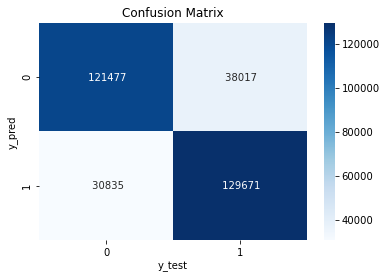

In [20]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cm=confusion_matrix(y_test,y_pred1)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

print(classification_report(y_test,y_pred1))

In [209]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(128,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(256,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(512,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dropout(0.5)(x)
x=Dense(2,activation='softmax')(x)
model2=Model(i,x)
model2.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 116)]             0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 116, 20)           10308040  
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 114, 128)          7808      
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 38, 128)           0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 36, 256)           98560     
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 12, 256)           0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 10, 512)           393

In [211]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_history = model2.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
10000/10000 [==============================] - 1100s 110ms/step - loss: 0.4748 - accuracy: 0.7721 - val_loss: 0.4560 - val_accuracy: 0.7821
Epoch 2/2
10000/10000 [==============================] - 1103s 110ms/step - loss: 0.4470 - accuracy: 0.7889 - val_loss: 0.4517 - val_accuracy: 0.7859


In [212]:
# Evaluate the model on test data
loss_model2, accuracy_model2 = model2.evaluate(data_test, y_test)

print(f"Test Loss on model1: {loss_model2}")
print(f"Test Accuracy on model1: {accuracy_model2}")

10000/10000 [==============================] - 25s 3ms/step - loss: 0.4517 - accuracy: 0.7859
Test Loss on model1: 0.45170214772224426
Test Accuracy on model1: 0.7858562469482422


In [215]:
y_pred2=model2.predict(data_test)
print(y_pred2) 
y_pred2=np.argmax(y_pred2,axis=1)
print(y_pred2)

[[0.22824988 0.7717501 ]
 [0.05697548 0.9430246 ]
 [0.312855   0.687145  ]
 ...
 [0.01727487 0.9827252 ]
 [0.6416466  0.35835335]
 [0.8714182  0.12858182]]
[1 1 1 ... 1 0 0]


              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



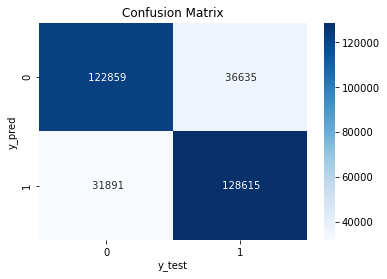

In [216]:
cm=confusion_matrix(y_test,y_pred2)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

print(classification_report(y_test,y_pred2))

In [218]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(128,5,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(256,5,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(512,5,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dropout(0.5)(x)
x=Dense(2,activation='softmax')(x)
model3=Model(i,x)
model3.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 116)]             0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 116, 20)           10308040  
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 112, 128)          12928     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 37, 128)           0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 33, 256)           164096    
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 11, 256)           0         
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 7, 512)            655

In [219]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_history = model3.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
10000/10000 [==============================] - 1147s 115ms/step - loss: 0.5301 - accuracy: 0.7303 - val_loss: 0.5160 - val_accuracy: 0.7388
Epoch 2/2
10000/10000 [==============================] - 1146s 115ms/step - loss: 0.5073 - accuracy: 0.7463 - val_loss: 0.5128 - val_accuracy: 0.7424


In [220]:
# Evaluate the model on test data
loss_model3, accuracy_model3 = model3.evaluate(data_test, y_test)

print(f"Test Loss on model1: {loss_model3}")
print(f"Test Accuracy on model1: {accuracy_model3}")

10000/10000 [==============================] - 27s 3ms/step - loss: 0.5128 - accuracy: 0.7424
Test Loss on model1: 0.5127728581428528
Test Accuracy on model1: 0.7423843741416931


In [221]:
y_pred3=model3.predict(data_test)
print(y_pred3) 
y_pred3=np.argmax(y_pred3,axis=1)
print(y_pred3)

[[0.15982752 0.84017247]
 [0.04380956 0.9561904 ]
 [0.46008712 0.5399129 ]
 ...
 [0.17096362 0.8290364 ]
 [0.59622467 0.4037753 ]
 [0.8260239  0.17397615]]
[1 1 1 ... 1 0 0]


              precision    recall  f1-score   support

           0       0.76      0.71      0.73    159494
           1       0.73      0.77      0.75    160506

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



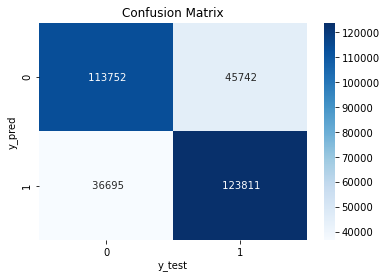

In [222]:
cm=confusion_matrix(y_test,y_pred3)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

print(classification_report(y_test,y_pred3))

In [223]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=GlobalAveragePooling1D()(x)
x=Dense(2,activation='softmax')(x)
model4=Model(i,x)
model4.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 116)]             0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 116, 20)           10308040  
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 114, 64)           3904      
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 38, 64)            0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 36, 128)           24704     
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 12, 128)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0  

In [224]:
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_history = model4.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
10000/10000 [==============================] - 1107s 111ms/step - loss: 0.4785 - accuracy: 0.7691 - val_loss: 0.4636 - val_accuracy: 0.7789
Epoch 2/2
10000/10000 [==============================] - 1110s 111ms/step - loss: 0.4506 - accuracy: 0.7867 - val_loss: 0.4563 - val_accuracy: 0.7821


In [225]:
# Evaluate the model on test data
loss_model4, accuracy_model4 = model4.evaluate(data_test, y_test)

print(f"Test Loss on model1: {loss_model4}")
print(f"Test Accuracy on model1: {accuracy_model4}")

10000/10000 [==============================] - 22s 2ms/step - loss: 0.4563 - accuracy: 0.7821
Test Loss on model1: 0.4562525451183319
Test Accuracy on model1: 0.7821218967437744


In [226]:
y_pred4=model4.predict(data_test)
print(y_pred4) 
y_pred4=np.argmax(y_pred4,axis=1)
print(y_pred4)

[[0.2786234  0.7213766 ]
 [0.08126904 0.918731  ]
 [0.41988304 0.580117  ]
 ...
 [0.03700705 0.962993  ]
 [0.66428256 0.3357174 ]
 [0.9338638  0.06613623]]
[1 1 1 ... 1 0 0]


              precision    recall  f1-score   support

           0       0.80      0.75      0.77    159494
           1       0.77      0.82      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



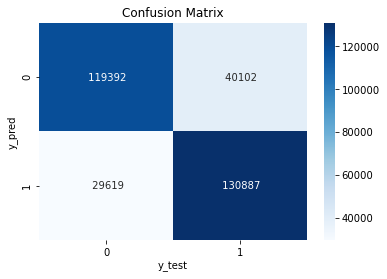

In [227]:
cm=confusion_matrix(y_test,y_pred4)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

print(classification_report(y_test,y_pred4))

In [150]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

# # Parameters
# max_words = V  # Assuming V is the number of unique tokens
# embedding_dim = 100  # Assuming D is the embedding dimension
# maxlen = T  # Assuming T is the maximum sequence length

# # Create a Sequential model
# model = Sequential()

# # Add Embedding layer
# embedding_layer = Embedding(max_words + 1, embedding_dim, input_length=maxlen)
# model.add(embedding_layer)

# # Now you can obtain the output of the embedding layer
# # and use it as input to subsequent layers
# model.add(Conv1D(32, 3, activation='relu'))  # Conv1D layer
# model.add(MaxPooling1D(3))  # MaxPooling1D layer
# model.add(Conv1D(64, 3, activation='relu'))  # Conv1D layer
# model.add(MaxPooling1D(3))  # MaxPooling1D layer
# model.add(Conv1D(128, 3, activation='relu'))  # Conv1D layer
# model.add(GlobalMaxPooling1D())  # GlobalMaxPooling1D layer
# model.add(Dense(1, activation='sigmoid'))  # Output layer with softmax activation

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 116, 100)          45839200  
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 114, 32)           9632      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 36, 64)            6208      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 10, 128)           24704     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)              